Exploring the $\chi^2$ distribution
===

Start with some model to generate random data.  <br> 
We'll use $0.2+\frac{sin(x)}{x+1}$ over the range $0\leq x<15$ <br>
Generate $N$ random numbers according to this distribution and make a histogram of the results using 30 bins. 

An easy way to generate random numbers according to an arbitrary distribution is to use rejection sampling (here's a great [decription  of the technique](https://matthewfeickert.github.io/Statistics-Notes/notebooks/simulation/Rejection-Sampling-MC.html) )

1) Make a histogram of your random distribution.  Verify that the the numbers you generated agree with the shape of the function.  Generate at least 10000 points and plot your data in a histogram with errorbars.  You can use numpy+matplotlib+etc, PyROOT, or a mix.  Think about how to appropriately normalize your function, then overlay it with the data.  The normalization depends on the number of bins, the bin range and the number of points thrown.  You may find it easier to first nromalize the area of your function to 1.0, thus turning it into a proper PDF.  

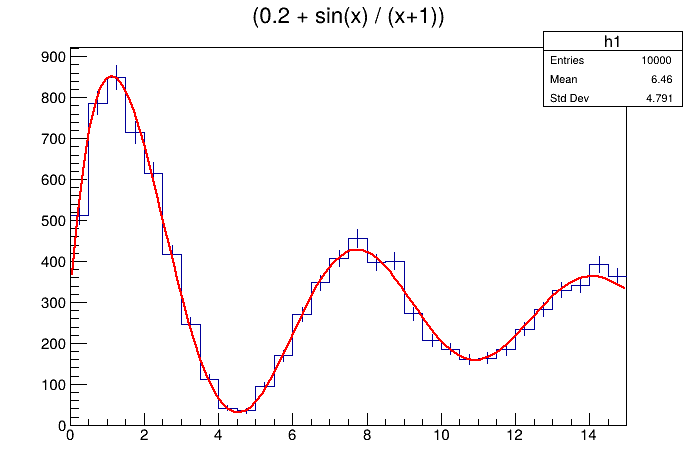

In [1]:
# your work goes here
import ROOT as R
import numpy as np

npoints = 10000
xmin = 0
xmax = 15
nbins = 30

#area = integrate.quad(lambda x: 0.2 + np.sin(x) / (x+1.0), 0, 15)

tc = R.TCanvas()
tfDist=R.TF1("tfDist","(0.2 + sin(x) / (x+1))", xmin, xmax, 0)
func_area = tfDist.Integral(xmin, xmax)
#print(f"area: {area}")
#tfNorm=R.TF1("tfNorm","(0.2 + sin(x) / (x+1))/[0]", xmin, xmax, 1)
#tfNorm.SetParameter(0,area)
#tfNorm.Update()


h1=R.TH1F("h1","(0.2 + sin(x) / (x+1))", nbins, xmin, xmax) # match range of our function
# fill 10000 times with a single sample from the PDF
h1.FillRandom("tfDist", npoints)
# h1.Scale(1.0/h1.Integral(xmin, xmax))
bin_counts = h1.Integral()*h1.GetBinWidth(1)
scaled = bin_counts/func_area
tfRenorm=R.TF1("tfRenorm","[0]*(0.2 + sin(x) / (x+1))", xmin, xmax, 1)
tfRenorm.SetParameter(0,scaled)
tfRenorm.Update()

h1.Draw("hist e")
tfRenorm.Draw("same")
tc.Draw("same")

2) Repeat the above experiment at least 1000 times.  For each experiment calculate the $\chi^2$ of your data with respect to your (properly normalized) model.  Plot (histogram) the $\chi^2$ distribution and compare it to the functional form of the $\chi^2(ndof=30)$ distribution.  You can find the form of the $\chi^2(ndof)$ PDF function in many places and implement it using the Gamma function or use a premade function, eg:
* [wikipedia](https://en.wikipedia.org/wiki/Chi-squared_distribution)
* [scipy.stats.chi2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2)

Running 1000 experiments...
  Experiment 100/1000
  Experiment 200/1000
  Experiment 300/1000
  Experiment 400/1000
  Experiment 500/1000
  Experiment 600/1000
  Experiment 700/1000
  Experiment 800/1000
  Experiment 900/1000
  Experiment 1000/1000
Chi-squared analysis complete!
Mean chi-squared: 30.09
Expected mean (ndof): 30
Std dev chi-squared: 8.03
Expected std dev: 7.75

Canvases created:
  tc_chi2: Chi-squared distribution comparison
  tc_example: Example histogram with fitted function


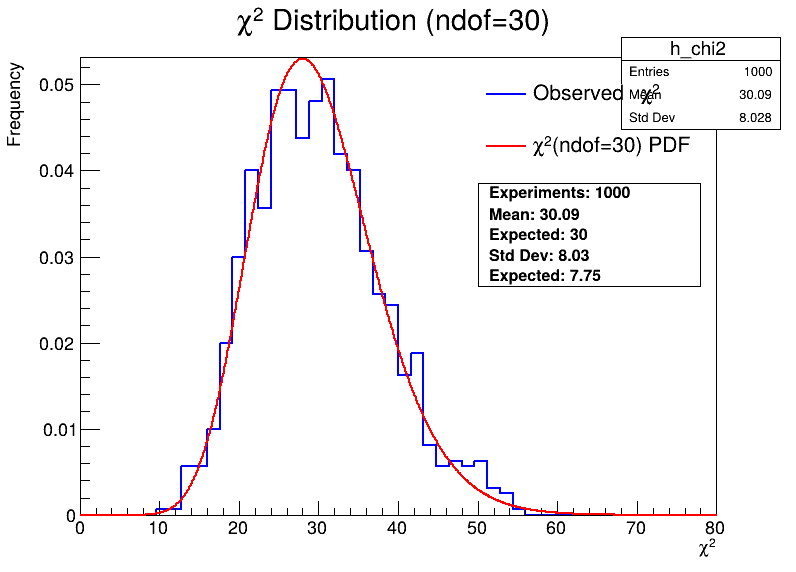

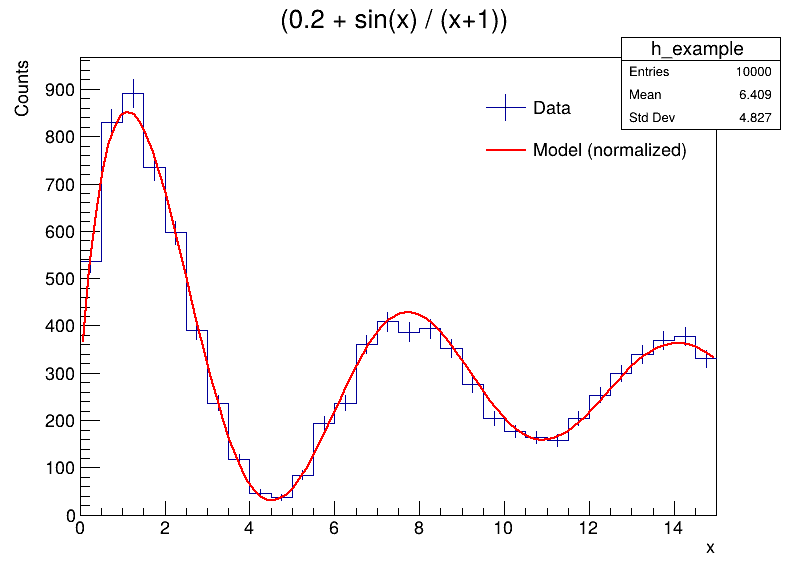

In [2]:
# your work goes here
import ROOT as R
import numpy as np
from scipy.stats import chi2

# Parameters
npoints = 10000
xmin = 0
xmax = 15
nbins = 30
nexperiments = 1000
ndof = nbins  # degrees of freedom = number of bins

# Define the original distribution function
tfDist = R.TF1("tfDist", "(0.2 + sin(x) / (x+1))", xmin, xmax, 0)
func_area = tfDist.Integral(xmin, xmax)

# Calculate the normalization factor for overlay
# We want: integral of normalized function over range = npoints * bin_width
bin_width = (xmax - xmin) / nbins
scaling_factor = npoints * bin_width / func_area

# Create normalized function for chi-squared calculation
tfNorm = R.TF1("tfNorm", f"[0]*(0.2 + sin(x) / (x+1))", xmin, xmax, 1)
tfNorm.SetParameter(0, scaling_factor)

# Array to store chi-squared values
chi2_values = []

print(f"Running {nexperiments} experiments...")
for iexp in range(nexperiments):
    if (iexp + 1) % 100 == 0:
        print(f"  Experiment {iexp + 1}/{nexperiments}")
    
    # Create histogram and fill with random samples
    h_temp = R.TH1F(f"h_temp_{iexp}", "Temporary histogram", nbins, xmin, xmax)
    h_temp.FillRandom("tfDist", npoints)
    
    # Calculate chi-squared
    chi2_val = 0.0
    for ibin in range(1, nbins + 1):
        # Get bin center and observed count
        bin_center = h_temp.GetBinCenter(ibin)
        observed = h_temp.GetBinContent(ibin)
        error = h_temp.GetBinError(ibin)
        
        # Get expected count from normalized function
        expected = tfNorm.Eval(bin_center)
        
        # Add to chi-squared (avoid division by zero)
        if expected > 0:
            chi2_val += (observed - expected)**2 / expected
    
    chi2_values.append(chi2_val)
    
    # Clean up
    h_temp.Delete()

print(f"Chi-squared analysis complete!")
print(f"Mean chi-squared: {np.mean(chi2_values):.2f}")
print(f"Expected mean (ndof): {ndof}")
print(f"Std dev chi-squared: {np.std(chi2_values):.2f}")
print(f"Expected std dev: {np.sqrt(2*ndof):.2f}")

# Create canvas for chi-squared distribution
tc_chi2 = R.TCanvas("tc_chi2", "Chi-Squared Distribution", 800, 600)

# Create histogram of chi-squared values
h_chi2 = R.TH1F("h_chi2", f"#chi^{{2}} Distribution (ndof={ndof}); #chi^{{2}}; Frequency", 
                50, 0, 80)
for val in chi2_values:
    h_chi2.Fill(val)

# Normalize histogram to unit area for comparison with PDF
h_chi2.Scale(1.0 / (h_chi2.Integral() * h_chi2.GetBinWidth(1)))

# Create theoretical chi-squared PDF function
# Using scipy to get the PDF values, then create a TF1
x_range = np.linspace(0, 80, 1000)
chi2_pdf = chi2.pdf(x_range, ndof)

# Create TGraph for the theoretical distribution
gr_theory = R.TGraph(len(x_range), x_range, chi2_pdf)
gr_theory.SetLineColor(R.kRed)
gr_theory.SetLineWidth(2)
gr_theory.SetLineStyle(1)

# Draw
h_chi2.SetLineColor(R.kBlue)
h_chi2.SetLineWidth(2)
h_chi2.Draw("hist")
gr_theory.Draw("L same")

# Add legend
legend = R.TLegend(0.6, 0.7, 0.88, 0.88)
legend.AddEntry(h_chi2, "Observed #chi^{2}", "l")
legend.AddEntry(gr_theory, f"#chi^{{2}}(ndof={ndof}) PDF", "l")
legend.SetBorderSize(0)
legend.SetFillStyle(0)
legend.Draw()

# Add statistics box
stats_text = R.TPaveText(0.6, 0.5, 0.88, 0.68, "NDC")
stats_text.AddText(f"Experiments: {nexperiments}")
stats_text.AddText(f"Mean: {np.mean(chi2_values):.2f}")
stats_text.AddText(f"Expected: {ndof}")
stats_text.AddText(f"Std Dev: {np.std(chi2_values):.2f}")
stats_text.AddText(f"Expected: {np.sqrt(2*ndof):.2f}")
stats_text.SetBorderSize(1)
stats_text.SetFillColor(0)
stats_text.SetTextAlign(12)
stats_text.Draw()

tc_chi2.Update()

# Create canvas for an example histogram with fit
tc_example = R.TCanvas("tc_example", "Example Histogram with Function", 800, 600)

# Create and fill one example histogram
h_example = R.TH1F("h_example", "(0.2 + sin(x) / (x+1)); x; Counts", nbins, xmin, xmax)
h_example.FillRandom("tfDist", npoints)

# Draw example
h_example.Draw("hist e")
tfNorm.SetLineColor(R.kRed)
tfNorm.SetLineWidth(2)
tfNorm.Draw("same")

# Add legend
legend_ex = R.TLegend(0.6, 0.7, 0.88, 0.85)
legend_ex.AddEntry(h_example, "Data", "lep")
legend_ex.AddEntry(tfNorm, "Model (normalized)", "l")
legend_ex.SetBorderSize(0)
legend_ex.SetFillStyle(0)
legend_ex.Draw()

tc_example.Update()

print("\nCanvases created:")
print("  tc_chi2: Chi-squared distribution comparison")
print("  tc_example: Example histogram with fitted function")

**Only required for Phys5630**

3) Modify your code above to perform the following study. <br>
Repeat (2) for nbins = $ndof = 30, 50, 75, 100$ and calculate the reduced $\chi^2$, eg $\chi^2/ndof$ for each experiment.  Plot the mean value of the reduced $\chi^2$ with errorbars versus $ndof$.  Make a table comparing your calculations to the expected results.

In [8]:
import ROOT as R
import numpy as np
from scipy.stats import chi2

# Disable ROOT's automatic memory management to prevent issues
R.TH1.AddDirectory(False)

# Parameters
npoints = 10000
xmin = 0
xmax = 15
nexperiments = 1000
bins_list = [30, 50, 75, 100]

# Define the original distribution function
tfDist = R.TF1("tfDist", "(0.2 + sin(x) / (x+1))", xmin, xmax, 0)
func_area = tfDist.Integral(xmin, xmax)

# Storage for results
results = {
    'ndof': [],
    'mean_reduced_chi2': [],
    'std_reduced_chi2': [],
    'stderr_reduced_chi2': []
}

print("Running reduced chi-squared study...")
print("=" * 60)

for nbins in bins_list:
    ndof = nbins
    bin_width = (xmax - xmin) / nbins
    scaling_factor = npoints * bin_width / func_area
    
    # Create normalized function for this bin configuration
    tfNorm_local = R.TF1(f"tfNorm_{nbins}", f"{scaling_factor}*(0.2 + sin(x) / (x+1))", xmin, xmax)
    
    reduced_chi2_values = []
    
    print(f"\nndof = {ndof} (nbins = {nbins}):")
    for iexp in range(nexperiments):
        if (iexp + 1) % 200 == 0:
            print(f"  Experiment {iexp + 1}/{nexperiments}")
        
        # Create and fill histogram
        h_temp = R.TH1F("h_temp", "Temporary", nbins, xmin, xmax)
        h_temp.FillRandom("tfDist", npoints)
        
        # Calculate chi-squared
        chi2_val = 0.0
        for ibin in range(1, nbins + 1):
            # Get bin center and observed count
            bin_center = h_temp.GetBinCenter(ibin)
            observed = h_temp.GetBinContent(ibin)
            error = h_temp.GetBinError(ibin)
            
            # Get expected count from normalized function
            expected = tfNorm_local.Eval(bin_center)
            
            # Add to chi-squared (avoid division by zero)
            if error > 0:
                chi2_val += (observed - expected)**2 / error**2
        
        # Calculate reduced chi-squared
        reduced_chi2 = chi2_val / ndof
        reduced_chi2_values.append(reduced_chi2)
        
        # Explicitly delete the histogram
        del h_temp
    
    # Calculate statistics
    mean_red_chi2 = np.mean(reduced_chi2_values)
    std_red_chi2 = np.std(reduced_chi2_values, ddof=1)
    stderr_red_chi2 = std_red_chi2 / np.sqrt(nexperiments)
    
    results['ndof'].append(ndof)
    results['mean_reduced_chi2'].append(mean_red_chi2)
    results['std_reduced_chi2'].append(std_red_chi2)
    results['stderr_reduced_chi2'].append(stderr_red_chi2)
    
    print(f"  Mean reduced χ²: {mean_red_chi2:.4f} ± {stderr_red_chi2:.4f}")
    print(f"  Std dev: {std_red_chi2:.4f}")
    
    # Clean up the function
    del tfNorm_local

print("\n" + "=" * 60)
print("Study complete!\n")

# Create table
print("RESULTS TABLE")
print("=" * 80)
print(f"{'ndof':<10} {'Mean χ²/ndof':<20} {'Std Dev':<15} {'Expected Mean':<15} {'Difference':<15}")
print("-" * 80)

for i, ndof in enumerate(results['ndof']):
    mean_val = results['mean_reduced_chi2'][i]
    stderr_val = results['stderr_reduced_chi2'][i]
    std_val = results['std_reduced_chi2'][i]
    expected_mean = 1.0
    difference = mean_val - expected_mean
    
    print(f"{ndof:<10} {mean_val:.4f} ± {stderr_val:.4f}     {std_val:<15.4f} {expected_mean:<15.4f} {difference:+.4f}")

print("=" * 80)
print(f"\nNote: Expected mean for reduced χ² is 1.0 for all ndof")
print(f"Expected std dev ≈ √(2/ndof)")
print()

Running reduced chi-squared study...

ndof = 30 (nbins = 30):
  Experiment 200/1000
  Experiment 400/1000
  Experiment 600/1000
  Experiment 800/1000
  Experiment 1000/1000
  Mean reduced χ²: 1.0148 ± 0.0084
  Std dev: 0.2642

ndof = 50 (nbins = 50):
  Experiment 200/1000
  Experiment 400/1000
  Experiment 600/1000
  Experiment 800/1000
  Experiment 1000/1000
  Mean reduced χ²: 0.9978 ± 0.0065
  Std dev: 0.2069

ndof = 75 (nbins = 75):
  Experiment 200/1000
  Experiment 400/1000
  Experiment 600/1000
  Experiment 800/1000
  Experiment 1000/1000
  Mean reduced χ²: 1.0195 ± 0.0055
  Std dev: 0.1731

ndof = 100 (nbins = 100):
  Experiment 200/1000
  Experiment 400/1000
  Experiment 600/1000
  Experiment 800/1000
  Experiment 1000/1000
  Mean reduced χ²: 1.0304 ± 0.0049
  Std dev: 0.1555

Study complete!

RESULTS TABLE
ndof       Mean χ²/ndof         Std Dev         Expected Mean   Difference     
--------------------------------------------------------------------------------
30         1

In [5]:
# Create plot
tc_study = R.TCanvas("tc_study", "Reduced Chi-Squared vs ndof", 900, 700)
tc_study.SetGrid()


Canvas created: tc_study
Graph created: gr_data (TGraphErrors with error bars)


Warning in <TAxis::TAxis::SetRangeUser>: ufirst < fXmin, fXmin is used
Warning in <TAxis::TAxis::SetRangeUser>: ulast > fXmax, fXmax is used


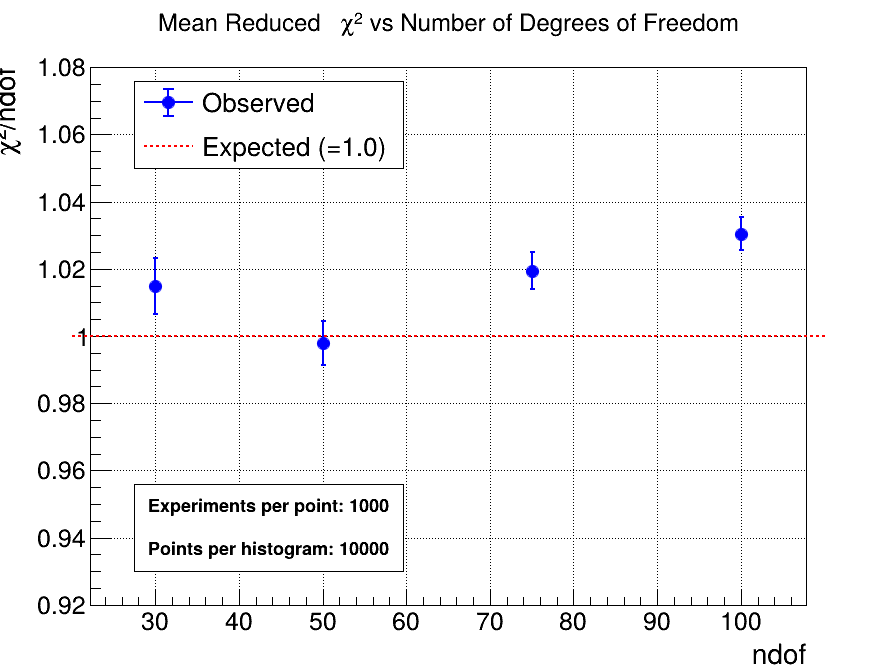

In [9]:

# Create TGraphErrors for the data
n_points = len(results['ndof'])
ndof_array = np.array(results['ndof'], dtype=float)
mean_array = np.array(results['mean_reduced_chi2'], dtype=float)
stderr_array = np.array(results['stderr_reduced_chi2'], dtype=float)
zeros_array = np.zeros(n_points, dtype=float)

gr_data = R.TGraphErrors(n_points, ndof_array, mean_array, zeros_array, stderr_array)
gr_data.SetTitle("Mean Reduced #chi^{2} vs Number of Degrees of Freedom; ndof; #bar{#chi^{2}}/ndof")
gr_data.SetMarkerStyle(20)
gr_data.SetMarkerSize(1.5)
gr_data.SetMarkerColor(R.kBlue)
gr_data.SetLineColor(R.kBlue)
gr_data.SetLineWidth(2)

# Set axis ranges
gr_data.GetXaxis().SetRangeUser(20, 110)
gr_data.GetYaxis().SetRangeUser(0.92, 1.08)
gr_data.GetXaxis().SetTitleSize(0.045)
gr_data.GetYaxis().SetTitleSize(0.045)
gr_data.GetXaxis().SetLabelSize(0.04)
gr_data.GetYaxis().SetLabelSize(0.04)

gr_data.Draw("APE")

# Add expected value line at y=1
line_expected = R.TLine(20, 1.0, 110, 1.0)
line_expected.SetLineColor(R.kRed)
line_expected.SetLineWidth(2)
line_expected.SetLineStyle(2)
line_expected.Draw("same")

# Add legend
legend_study = R.TLegend(0.15, 0.75, 0.45, 0.88)
legend_study.AddEntry(gr_data, "Observed", "lep")
legend_study.AddEntry(line_expected, "Expected (=1.0)", "l")
legend_study.SetBorderSize(1)
legend_study.SetFillColor(0)
legend_study.Draw()

# Add text box with info
info_text = R.TPaveText(0.15, 0.15, 0.45, 0.28, "NDC")
info_text.AddText(f"Experiments per point: {nexperiments}")
info_text.AddText(f"Points per histogram: {npoints}")
info_text.SetBorderSize(1)
info_text.SetFillColor(0)
info_text.SetTextAlign(12)
info_text.Draw()

tc_study.Draw()

print("Canvas created: tc_study")
print("Graph created: gr_data (TGraphErrors with error bars)")